<a href="https://colab.research.google.com/github/JeetRoy97/Analytics-Vidhya-Job-a-thon/blob/main/LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/dataset/train_E1GspfA.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/MyDrive/dataset/test_6QvDdzb.csv', parse_dates=['date'])

df = pd.concat([train, test], sort=False)

In [ ]:
test

,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5
...,...,...
7645,2022-03-28,19
7646,2022-03-28,20
7647,2022-03-28,21
7648,2022-03-28,22


In [ ]:
df

,date,hour,demand
0,2018-08-18,9,91.0
1,2018-08-18,10,21.0
2,2018-08-18,13,23.0
3,2018-08-18,14,104.0
4,2018-08-18,15,81.0
...,...,...,...
7645,2022-03-28,19,NaN
7646,2022-03-28,20,NaN
7647,2022-03-28,21,NaN
7648,2022-03-28,22,NaN


In [ ]:
# df.rename(columns = {'demand':'demandd'}, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25897 entries, 0 to 7649
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    25897 non-null  datetime64[ns]
 1   hour    25897 non-null  int64         
 2   demand  18247 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 809.3 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
hour,25897.0,12.592385,6.567287,0.0,8.0,13.0,18.0,23.0
demand,18247.0,73.991451,41.678988,1.0,43.0,71.0,98.0,379.0


In [ ]:
df.isnull().sum()

date         0
hour         0
demand    7650
dtype: int64

In [ ]:
test["date"].min(), test["date"].max()

(Timestamp('2021-03-01 00:00:00'), Timestamp('2022-03-28 00:00:00'))

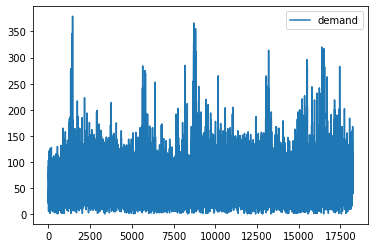

In [ ]:
df[["demand"]].plot()
plt.show(block=True)

In [ ]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['quarter_of_year'] = df.date.dt.quarter
df['week_of_year'] = df.date.dt.weekofyear
df['day_of_year'] = df.date.dt.dayofyear
df['day_of_month'] = df.date.dt.day
df['day_of_week'] = df.date.dt.dayofweek
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.5, size=(len(dataframe),))

In [ ]:
df.sort_values(by=['hour', 'date'], axis=0, inplace=True)

In [ ]:


pd.DataFrame({"demand": df["demand"].values[0:10],
              "lag1": df["demand"].shift(1).values[0:10],
              "lag2": df["demand"].shift(2).values[0:10],
              "lag3": df["demand"].shift(3).values[0:10],
              "lag4": df["demand"].shift(4).values[0:10]})



,demand,lag1,lag2,lag3,lag4
0,41.0,NaN,NaN,NaN,NaN
1,74.0,41.0,NaN,NaN,NaN
2,34.0,74.0,41.0,NaN,NaN
3,94.0,34.0,74.0,41.0,NaN
4,21.0,94.0,34.0,74.0,41.0
5,86.0,21.0,94.0,34.0,74.0
6,18.0,86.0,21.0,94.0,34.0
7,21.0,18.0,86.0,21.0,94.0
8,67.0,21.0,18.0,86.0,21.0
9,15.0,67.0,21.0,18.0,86.0


In [ ]:
df.groupby(["hour"])['demand'].head()

57     41.0
119    74.0
167    34.0
230    94.0
266    21.0
       ... 
12     21.0
41     73.0
72     79.0
118    68.0
135    39.0
Name: demand, Length: 120, dtype: float64

In [ ]:
df.groupby(["hour"])['demand'].transform(lambda x: x.shift(1))

57       NaN
119     41.0
167     74.0
230     34.0
266     94.0
        ... 
7561     NaN
7583     NaN
7605     NaN
7629     NaN
7649     NaN
Name: demand, Length: 25897, dtype: float64

In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['demand_lag_' + str(lag)] = dataframe.groupby(["hour"])['demand'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [ ]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [ ]:


pd.DataFrame({"demand": df["demand"].values[0:10],
              "roll2": df["demand"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["demand"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["demand"].shift(1).rolling(window=5).mean().values[0:10]})



,demand,roll2,roll3,roll5
0,41.0,NaN,NaN,NaN
1,74.0,NaN,NaN,NaN
2,34.0,57.5,NaN,NaN
3,94.0,54.0,49.666667,NaN
4,21.0,64.0,67.333333,NaN
5,86.0,57.5,49.666667,52.8
6,18.0,53.5,67.000000,61.8
7,21.0,52.0,41.666667,50.6
8,67.0,19.5,41.666667,48.0
9,15.0,44.0,35.333333,42.6


In [ ]:


def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['demand_roll_mean_' + str(window)] = dataframe.groupby(["hour"])['demand']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe



In [ ]:
df = roll_mean_features(df, [365, 546])

In [ ]:


pd.DataFrame({"demand": df["demand"].values[0:10],
              "roll2": df["demand"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["demand"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["demand"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["demand"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["demand"].shift(1).ewm(alpha=0.1).mean().values[0:10]})



,demand,roll2,ewm099,ewm095,ewm07,ewm02
0,41.0,NaN,NaN,NaN,NaN,NaN
1,74.0,NaN,41.000000,41.000000,41.000000,41.000000
2,34.0,57.5,73.673267,72.428571,66.384615,58.368421
3,94.0,54.0,34.396693,35.916865,43.086331,49.376384
4,21.0,64.0,93.403968,91.096188,79.016937,62.352137
5,86.0,57.5,21.724040,24.504789,38.306154,52.254182
6,18.0,53.5,85.357240,82.925240,71.716202,59.456224
7,21.0,52.0,18.673572,21.246262,34.106635,51.509899
8,67.0,19.5,20.976736,21.012313,24.931389,46.152894
9,15.0,44.0,66.539767,64.700616,54.379996,49.556062


In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['demand_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["hour"])['demand'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [ ]:


alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]



In [ ]:


df = ewm_features(df, alphas, lags)



In [ ]:


df = pd.get_dummies(df, columns=['hour', 'day_of_week', 'month'])



In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

In [ ]:
train = df.loc[(df["date"] < "2021-01-01"), :]

val = df.loc[(df["date"] >= "2021-01-01") & (df["date"] < "2022-02-28"), :]

cols = [col for col in train.columns if col not in ['date', "demand", "year"]]

Y_train = train['demand']
X_train = train[cols]

Y_val = val['demand']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((16942,), (16942, 107), (8341,), (8341, 107))

In [ ]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:


lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)



In [ ]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's SMAPE: 43.6652	valid_1's SMAPE: 6.20098
[200]	training's SMAPE: 43.1304	valid_1's SMAPE: 6.18627
[300]	training's SMAPE: 42.8623	valid_1's SMAPE: 6.20547
[400]	training's SMAPE: 42.6168	valid_1's SMAPE: 6.21263
Early stopping, best iteration is:
[202]	training's SMAPE: 43.1231	valid_1's SMAPE: 6.18526


In [ ]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [ ]:
smape(y_pred_val, Y_val)

6.185256048434611

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

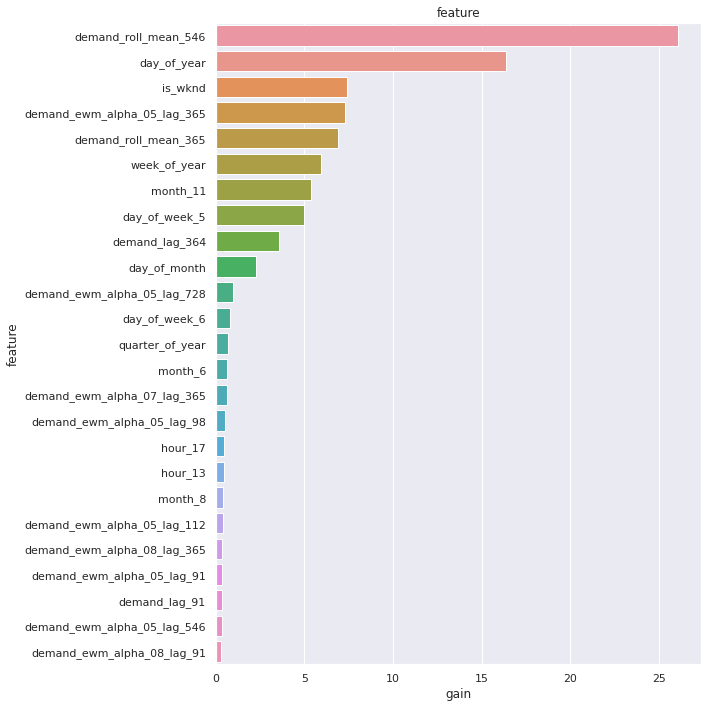

,feature,split,gain
18,demand_roll_mean_546,186,26.067113
2,day_of_year,387,16.373752
4,is_wknd,102,7.420522
61,demand_ewm_alpha_05_lag_365,61,7.317658
17,demand_roll_mean_365,90,6.897630
...,...,...,...
75,hour_11,0,0.000000
76,hour_12,0,0.000000
25,demand_ewm_alpha_095_lag_365,0,0.000000
39,demand_ewm_alpha_08_lag_105,0,0.000000


In [ ]:
plot_lgb_importances(model, num=30, plot=True)

In [ ]:
feat_imp = plot_lgb_importances(model, num=200)

low_importance = feat_imp[feat_imp["gain"] <= 0.005]["feature"].values

dff = df.drop(low_importance, axis=1)

cols_dff = [col for col in dff.columns if col not in ['date', 'id', "demand", "year"]]

                         feature  split       gain
18          demand_roll_mean_546    186  26.067113
2                    day_of_year    387  16.373752
4                        is_wknd    102   7.420522
61   demand_ewm_alpha_05_lag_365     61   7.317658
17          demand_roll_mean_365     90   6.897630
..                           ...    ...        ...
75                       hour_11      0   0.000000
76                       hour_12      0   0.000000
25  demand_ewm_alpha_095_lag_365      0   0.000000
39   demand_ewm_alpha_08_lag_105      0   0.000000
74                       hour_10      0   0.000000

[107 rows x 3 columns]


In [ ]:
train = dff.loc[~df.demand.isna()]
Y_train = train['demand']
X_train = train[cols_dff]


test = dff.loc[df.demand.isna()]
X_test = test[cols_dff]

In [ ]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [ ]:


lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols_dff)

In [ ]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

In [ ]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:


submission_df = test.loc[:, ["date", "demand"]]

submission_df['demand'] = test_preds

submission_df['date'] = submission_df.date



In [ ]:
test = pd.read_csv('/content/drive/MyDrive/dataset/test_6QvDdzb.csv', parse_dates=['date'])

In [ ]:
test

,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5
...,...,...
7645,2022-03-28,19
7646,2022-03-28,20
7647,2022-03-28,21
7648,2022-03-28,22


In [ ]:
submission_df['hour'] = test['hour']

In [ ]:
cols = submission_df.columns.tolist()
cols

['date', 'demand', 'hour']

In [ ]:
# cols1

In [ ]:
cols = submission_df.columns.tolist()
cols1 = [cols[0], cols[-1],cols[1]]
submission_df = submission_df[cols1]

In [ ]:
submission_df

,date,hour,demand
0,2021-03-01,0,56.376128
23,2021-03-02,0,58.769549
45,2021-03-03,0,57.818849
68,2021-03-04,0,58.112878
90,2021-03-05,0,59.061009
...,...,...,...
7561,2022-03-24,23,60.995639
7583,2022-03-25,23,62.386742
7605,2022-03-26,23,62.047949
7629,2022-03-27,23,61.540942


In [ ]:
submission_df = submission_df.sort_values(by = ['date', 'hour'], ascending = [True, True], na_position = 'first')
submission_df

,date,hour,demand
0,2021-03-01,0,56.376128
1,2021-03-01,1,57.754201
2,2021-03-01,2,57.586210
3,2021-03-01,3,57.754201
4,2021-03-01,5,52.518847
...,...,...,...
7645,2022-03-28,19,76.464155
7646,2022-03-28,20,67.639746
7647,2022-03-28,21,66.095357
7648,2022-03-28,22,64.563456


In [ ]:
# submission_df.rename(columns = {'demand':'demand'}, inplace = True)
submission_df

,date,hour,demand
0,2021-03-01,0,56.376128
1,2021-03-01,1,57.754201
2,2021-03-01,2,57.586210
3,2021-03-01,3,57.754201
4,2021-03-01,5,52.518847
...,...,...,...
7645,2022-03-28,19,76.464155
7646,2022-03-28,20,67.639746
7647,2022-03-28,21,66.095357
7648,2022-03-28,22,64.563456


In [ ]:
submission_df.to_csv("/content/drive/MyDrive/dataset/final_orig.csv", index=False)